<a href="https://colab.research.google.com/github/ashishpatel26/Covid19-Models/blob/master/Covid19_MutliModel_Approach_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [23]:
%tensorflow_version 1.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2
from tqdm import notebook
from sklearn.model_selection import StratifiedShuffleSplit
import warnings 
warnings.filterwarnings("ignore")

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import *
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.vgg19 import *
from tensorflow.keras.applications import vgg19
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils.data_utils import Sequence
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# from keras.utils import Sequence

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1
    plt.show()

In [0]:
train = '/content/drive/My Drive/dataset/train/'
test = '/content/drive/My Drive/dataset/test/'

In [0]:
class DataLoader():
  def __init__(self, path, dim = 224):
    self.path = path
    self.dim = dim

  def preprocessing(self,instancePath, preprocessing_input = vgg19.preprocess_input):
    image = load_img(instancePath, target_size=(self.dim, self.dim))
    image = img_to_array(image)
    image /= 255.0
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

  def prepare_train_data(self):
    X_train = []
    y_train = []
    for class_folder_name in os.listdir(self.path):
      class_folder_path = os.path.join(self.path, class_folder_name)
      for img in notebook.tqdm(os.listdir(class_folder_path)):
        imgpath = os.path.join(class_folder_path, img)
        img = self.preprocessing(imgpath)
        X_train.append(img)
        y_train.append(1 if class_folder_name == 'corona' else 0)
    
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')
    return X_train,y_train

In [47]:
dl = DataLoader(path = train, dim = 300)
X_train, y_train = dl.prepare_train_data()


X_train shape:(178, 300, 300, 3)
Y_train shape:(178,)


In [0]:
# from glob import glob
# images_per_class = {}
# for class_folder_name in os.listdir(path):
#     class_folder_path = os.path.join(path, class_folder_name)
#     class_label = class_folder_name
#     images_per_class[class_label] = []
#     for image_path in tqdm(glob(os.path.join(class_folder_path, "*.jpg"))):
#         image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
#         images_per_class[class_label].append(image_bgr)

In [0]:
# for key,value in images_per_class.items():
#     print("{0} -> {1}".format(key, len(value)))

In [0]:
dim = 300

In [51]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.01, random_state=42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(X_train, y_train):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = X_train[train_index], X_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

Using 160 for training and 18 for validation


In [52]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(160, 300, 300, 3) (160,) (18, 300, 300, 3) (18,)


In [0]:
epochs = 10
learning_rate = 0.0001
batch_size = 32
weights="/content/drive/My Drive/ashish_data/weight_augment.h5"

In [0]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=15, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,verbose=0, mode='auto')]

In [70]:
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *


vgg=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(dim,dim,3))
resnet=keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(dim,dim,3))


for layer in vgg.layers:
  layer.trainable = False
for layer in resnet.layers:
  layer.trainable = False
  
  
resnet_out = resnet.output
resnet_final=GlobalAveragePooling2D()(resnet_out)
vgg_out = vgg.output
vgg_final=GlobalAveragePooling2D()(vgg_out)


pre_combined_model = Concatenate()([resnet_final, vgg_final])


premodel= Dense(512,activation='relu')(pre_combined_model)
premodel1= Dense(1,activation='sigmoid')(premodel)

finalmodel=Model(inputs=[vgg.input,resnet.input],outputs=[premodel1])
finalmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [71]:
# model.load_weights('/content/drive/My Drive/dataset/Best Model/Mobilenet2.h5')
finalmodel.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [72]:
y_train

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1])

In [74]:
history=finalmodel.fit([x_train, x_train], y_train, epochs=10, batch_size=32)

Train on 160 samples
Epoch 1/10
160/160 [==============================] - 3s 17ms/sample - loss: 0.5034 - acc: 0.7563
Epoch 2/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.4815 - acc: 0.7688
Epoch 3/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.4720 - acc: 0.8125
Epoch 4/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.4467 - acc: 0.8625
Epoch 5/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.4305 - acc: 0.8250
Epoch 6/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.4331 - acc: 0.8250
Epoch 7/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.4050 - acc: 0.9000
Epoch 8/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.3877 - acc: 0.9062
Epoch 9/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.4058 - acc: 0.8375
Epoch 10/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.3731 - acc: 0.8813


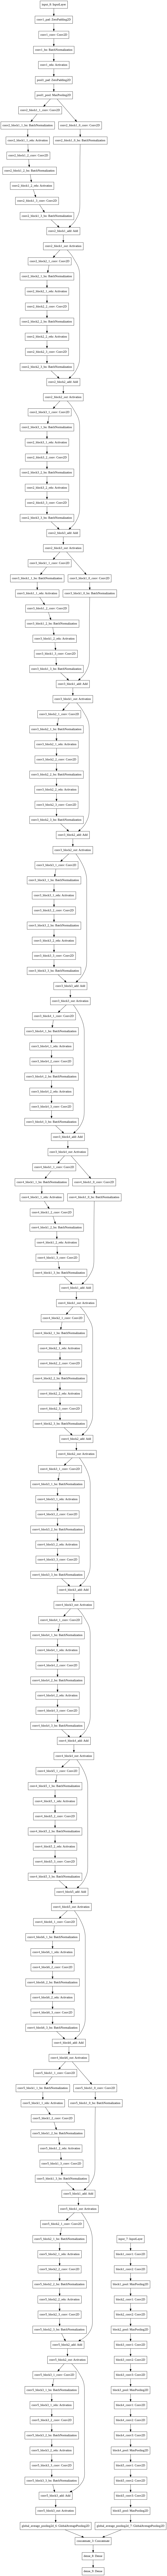

In [75]:
import tensorflow as tf

tf.keras.utils.plot_model(
    finalmodel, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [0]:
# train_imgen = ImageDataGenerator(rescale = 1./255, 
#                                    shear_range = 0.2, 
#                                    zoom_range = 0.2,
#                                    rotation_range=5.,
#                                    horizontal_flip = True,
#                                    vertical_flip=True)

# test_imgen = ImageDataGenerator(rescale = 1./255)


# def generate_generator_multiple(generator,X1,X2,batch_size=6, img_height=300,img_width=300):
# # def generate_generator_multiple(generator,X1,X2,Y1,Y2,batch_size=6, img_height=300,img_width=300):
#     print(
#         X1.shape)
#     # genX1 = generator.flow(X1,Y1,batch_size = batch_size,shuffle=True,seed=7)
    
#     genX1 = generator.flow(X1,batch_size = batch_size,shuffle=True,seed=7)
#     # genX1 = generator.flow(X1,batch_size = batch_size,shuffle=True,seed=7)
#     # genX2 = generator.flow(X2,Y2,batch_size = batch_size,shuffle=True,seed=7)
#     genX2 = generator.flow(X2,batch_size = batch_size,shuffle=True,seed=7)
#     while True:
#             X1i = genX1.next()
#             # Y1i = genX1.next()
#             X2i = genX2.next()
#             # Y2i = genX2.next()
#             print(X1i.shape)
            
#             yield [X1i, X2i]  #Yield both images and their mutual label
            
            
# # train_generator=generate_generator_multiple(train_imgen,x_train,x_train,y_train,y_train,batch_size=batch_size,img_height=300,img_width=300)       
# train_generator=generate_generator_multiple(train_imgen,x_train,x_train,batch_size=batch_size,img_height=300,img_width=300)       
     
# # test_generator=generate_generator_multiple(test_imgen,x_valid,x_valid,y_valid,y_valid,batch_size=batch_size,img_height=300,img_width=300)              
# test_generator=generate_generator_multiple(test_imgen,x_valid,x_valid,batch_size=batch_size,img_height=300,img_width=300)              
          
# history=finalmodel.fit_generator(train_generator,
#                         steps_per_epoch=x_train.shape[0]/batch_size,
#                         epochs = epochs,
#                         validation_data = test_generator,
#                         validation_steps = x_valid.shape[0]/batch_size,
#                         use_multiprocessing=True,
#                         shuffle=False)

In [76]:
import pandas as pd
result = pd.DataFrame(history.history)
result

,loss,acc
0,0.503365,0.75625
1,0.481487,0.76875
2,0.472044,0.81250
3,0.446705,0.86250
4,0.430499,0.82500
5,0.433062,0.82500
6,0.404964,0.90000
7,0.387699,0.90625
8,0.405835,0.83750
9,0.373144,0.88125


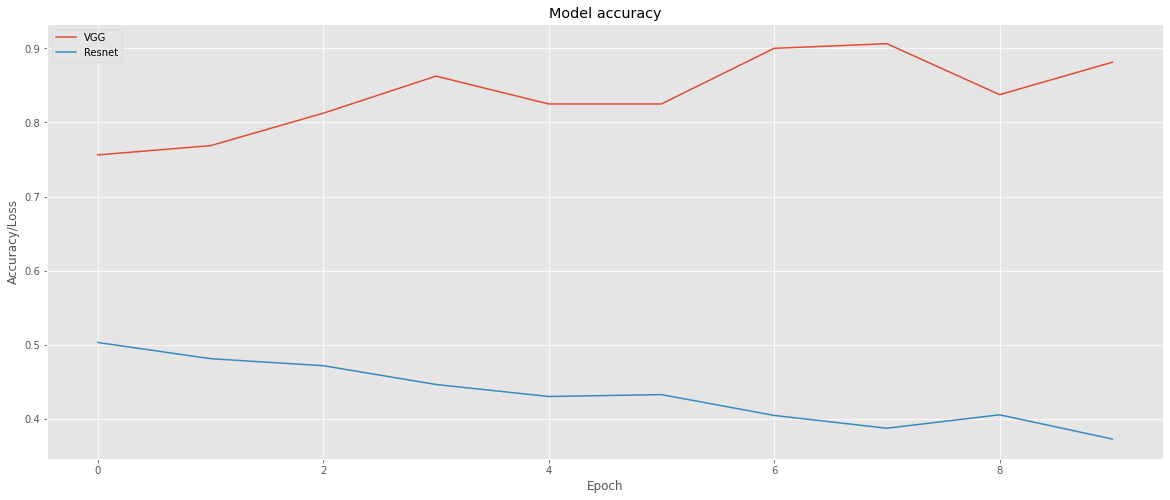

In [79]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

# Plot training & validation accuracy values
plt.figure(figsize=(20,8))
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['VGG', 'Resnet'], loc='upper left')
plt.show()

# Plot training & validation loss values
# plt.figure(figsize=(20,8))
# plt.plot(history.history['loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['VGG', 'Resnet'], loc='upper left')
# plt.show()

In [0]:
import datetime
result.to_csv(f"/content/drive/My Drive/dataset/result_{datetime.datetime.now()}.csv", index=False)

In [0]:
# y_valid1 = np.asarray(y_valid).astype(np.float32).reshape((-1,2))
# print(y_valid1.shape,y_valid.shape)

(18, 2) (18, 2)


In [81]:
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape

((160, 300, 300, 3), (160,), (18, 300, 300, 3), (18,))

In [83]:
print('\n# Evaluate on test data')
results = finalmodel.evaluate([x_valid,x_valid], y_valid, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
18/18 [==============================] - 2s 114ms/sample - loss: 0.8112 - acc: 0.5000
test loss, test acc: [0.8112489581108093, 0.5]


In [0]:
import os
covid = os.listdir('/content/drive/My Drive/dataset/test/COVID-19')
covid

['1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
 'covid-19-pneumonia-15-PA.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 'B2D20576-00B7-4519-A415-72DE29C90C34.jpeg',
 '1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg',
 '8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg',
 '1-s2.0-S0929664620300449-gr2_lrg-d.jpg',
 '6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg',
 '9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg']

In [0]:
# ------ TESTING ------
x_test = []
for f in tqdm(covid, miniters=100):
    img = cv2.imread('/content/drive/My Drive/dataset/test/COVID-19/{}'.format(f))
    x_test.append(cv2.resize(img, (dim, dim)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

(10, 300, 300, 3)


In [0]:
if os.path.isfile(weights):
    finalmodel.load_weights(weights)

In [93]:
y_pred = finalmodel.predict([x_valid,x_valid], verbose=1)
y_pred = np.argmax(y_pred, axis=1)
# p_test = finalmodel.predict([x_test,x_test], verbose=1)

18/18 [==============================] - 0s 10ms/sample


In [98]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print('Classification Report VGG')
target_names = ['pneumonia', 'corona']
print(classification_report(y_pred, y_valid))

Classification Report VGG
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        18
           1       0.00      0.00      0.00         0

    accuracy                           0.50        18
   macro avg       0.50      0.25      0.33        18
weighted avg       1.00      0.50      0.67        18



In [99]:
print("Precision score: {}".format(precision_score(y_pred, y_valid)))
print("Recall score: {}".format(recall_score(y_pred, y_valid)))
print("F1 Score: {}".format(f1_score(y_pred, y_valid)))

Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0
